In [ ]:
!pip install rasterio numpy matplotlib scikit-learn tensorflow


In [ ]:
import rasterio
import numpy as np

file_path = "/content/drive/MyDrive/GEE_Phase2_AI_Input/TN_MultiSensor_Features.tif"

with rasterio.open(file_path) as src:
    img = src.read()        # shape: (bands, height, width)
    profile = src.profile

print("Image shape:", img.shape)


Image shape: (4, 6076, 4598)


In [ ]:
# Convert to (pixels, features)
bands, height, width = img.shape
X = img.reshape(bands, -1).T

# Remove invalid pixels
X = np.nan_to_num(X)

print("Training samples:", X.shape)


Training samples: (27937448, 4)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_dim = X_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428 (1.67 KB)

 Trainable params: 428 (1.67 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=20,
    batch_size=2048,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
12278/12278 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0060 - val_loss: 8.5298e-06
Epoch 2/20
12278/12278 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 1.3093e-05 - val_loss: 8.2941e-06
Epoch 3/20
12278/12278 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 1.3010e-05 - val_loss: 7.7621e-06
Epoch 4/20
12278/12278 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 1.2999e-05 - val_loss: 7.5816e-06
Epoch 5/20
12278/12278 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 1.2982e-05 - val_loss: 7.7970e-06
Epoch 6/20
12278/12278 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 1.3000e-05 - val_loss: 7.6048e-06
Epoch 7/20
12278/12278 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 1.2978e-05 - val_loss: 8.2007e-06
Epoch 8/20
12278/12278 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 1.2970e-05 - val_loss: 7.6843e-06
Epoch 9/20
12278/12278 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 1.2955e-05 - val_loss: 8.5769e-06
Epoch 10/20
12278/12278 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 1.2949e-05 - val_loss: 7.7199e-06
Epoch 11/20
1

In [ ]:
# Batch size (safe for Colab)
batch_size = 50000

mse_list = []

for i in range(0, X_scaled.shape[0], batch_size):
    batch = X_scaled[i:i+batch_size]
    batch_pred = autoencoder.predict(batch, verbose=0)
    batch_mse = np.mean(np.power(batch - batch_pred, 2), axis=1)
    mse_list.append(batch_mse)

# Combine all batches
mse = np.concatenate(mse_list)

print("Anomaly score range:", mse.min(), mse.max())


Anomaly score range: 2.365649e-09 0.009019356


In [ ]:
anomaly_map = mse.reshape(height, width)


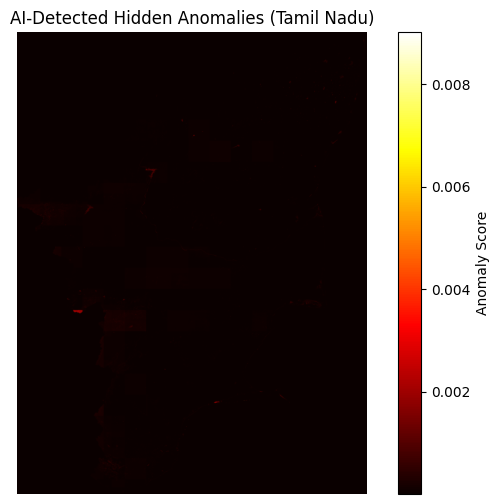

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(anomaly_map, cmap='hot')
plt.colorbar(label='Anomaly Score')
plt.title('AI-Detected Hidden Anomalies (Tamil Nadu)')
plt.axis('off')
plt.show()


In [ ]:
output_path = "/content/drive/MyDrive/GEE_Phase2_AI_Input/TN_AI_Anomaly_Map.tif"

with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype='float32',
    crs=profile['crs'],
    transform=profile['transform']
) as dst:
    dst.write(anomaly_map.astype('float32'), 1)


In [ ]:
# Reshape flat anomaly scores to image
anomaly_map = mse.reshape(height, width)

print("Anomaly map shape:", anomaly_map.shape)


Anomaly map shape: (6076, 4598)


In [ ]:
# Normalize anomaly map (0–1)
amin, amax = anomaly_map.min(), anomaly_map.max()
anomaly_norm = (anomaly_map - amin) / (amax - amin + 1e-8)

# Define risk thresholds
low_risk    = anomaly_norm < 0.6
medium_risk = (anomaly_norm >= 0.6) & (anomaly_norm < 0.8)
high_risk   = anomaly_norm >= 0.8

print("High-risk pixels:", high_risk.sum())


High-risk pixels: 2


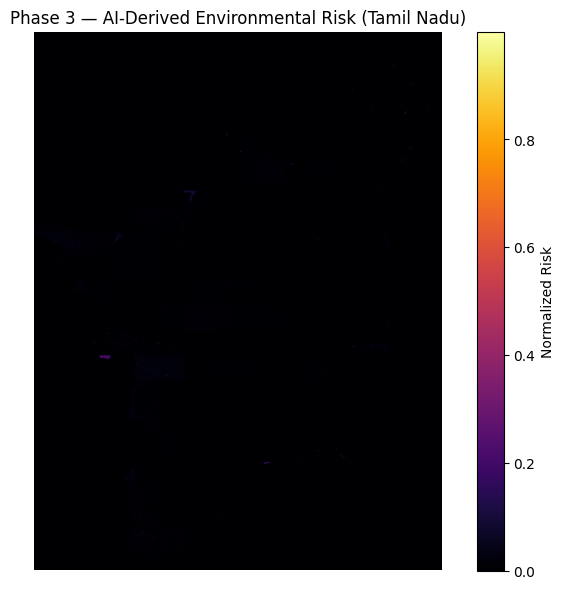

In [ ]:
plt.figure(figsize=(9,7))
plt.imshow(anomaly_norm, cmap='inferno')
plt.colorbar(label='Normalized Risk')
plt.title('Phase 3 — AI-Derived Environmental Risk (Tamil Nadu)')
plt.axis('off')
plt.show()


In [ ]:
# -----------------------------
# BATCH-WISE FEATURE IMPORTANCE
# -----------------------------

batch_size = 50000
feature_error_sum = np.zeros(X_scaled.shape[1])
count = 0

for i in range(0, X_scaled.shape[0], batch_size):
    batch = X_scaled[i:i+batch_size]
    batch_pred = autoencoder.predict(batch, verbose=0)

    # feature-wise squared error
    batch_error = np.mean((batch - batch_pred) ** 2, axis=0)

    feature_error_sum += batch_error
    count += 1

# Average contribution per feature
feature_errors = feature_error_sum / count

features = ['NDVI', 'Radar', 'SoilMoisture', 'Rainfall']

for f, e in zip(features, feature_errors):
    print(f"{f} contribution:", round(float(e), 6))


NDVI contribution: 5e-06
Radar contribution: 9e-06
SoilMoisture contribution: 2e-06
Rainfall contribution: 3.2e-05


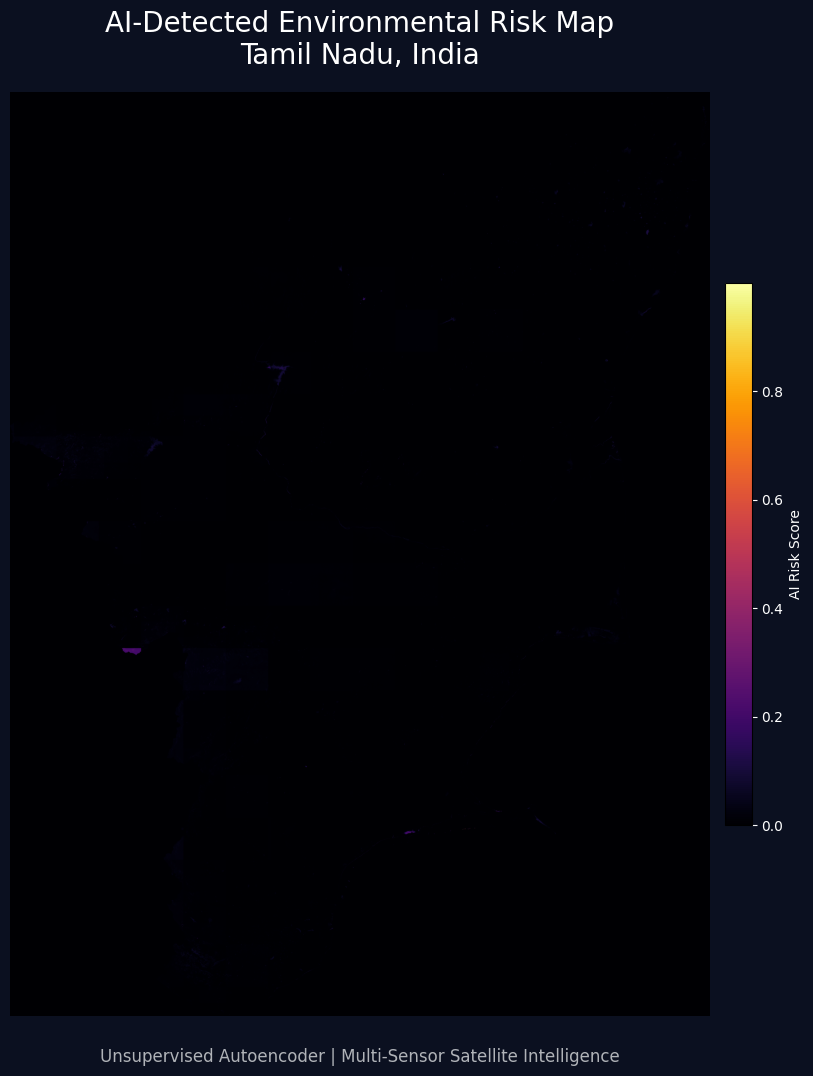

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12), facecolor='#0B1020')

# Show anomaly map
plt.imshow(anomaly_norm, cmap='inferno')
plt.axis('off')

# Title
plt.title(
    "AI-Detected Environmental Risk Map\nTamil Nadu, India",
    fontsize=20,
    color='white',
    pad=20
)

# Subtitle
plt.text(
    0.5, -0.05,
    "Unsupervised Autoencoder | Multi-Sensor Satellite Intelligence",
    fontsize=12,
    color='#B0B3B8',
    ha='center',
    transform=plt.gca().transAxes
)

# Colorbar
cbar = plt.colorbar(fraction=0.035, pad=0.02)
cbar.set_label("AI Risk Score", color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.show()


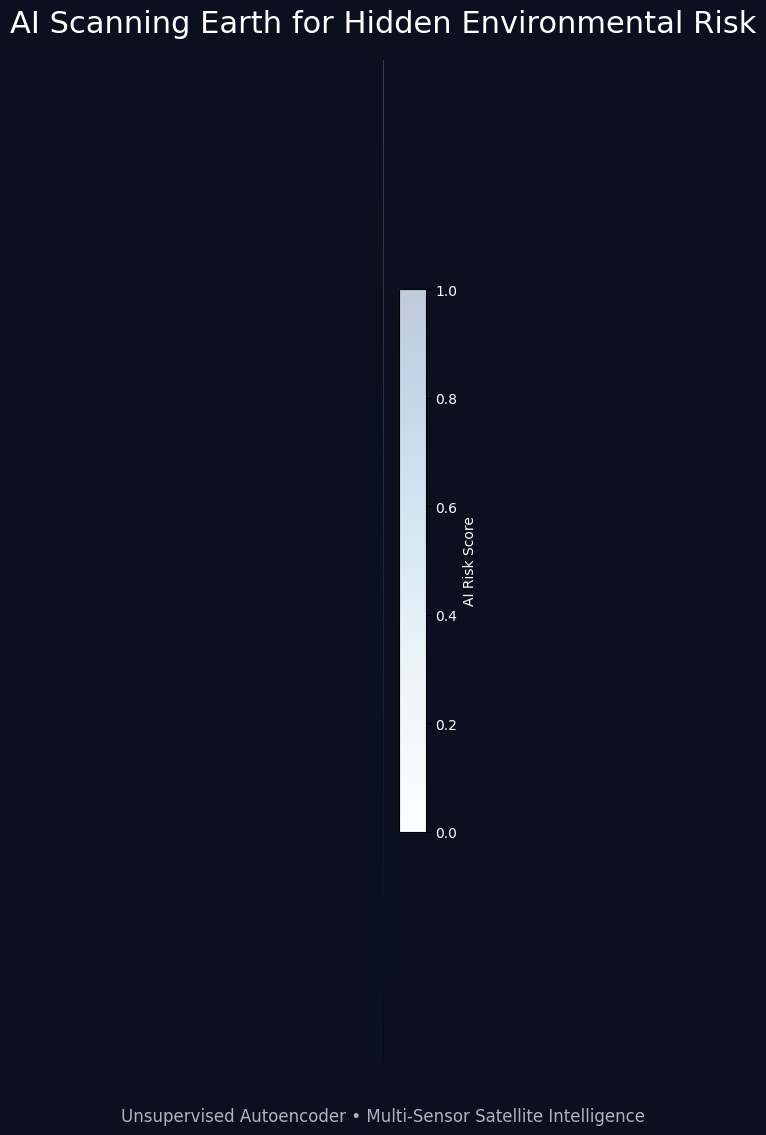

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

h, w = anomaly_norm.shape
scan = np.linspace(0, 1, h).reshape(-1, 1)

plt.figure(figsize=(10, 13), facecolor='#0B1020')

# Base heatmap
plt.imshow(anomaly_norm, cmap='inferno')
plt.imshow(scan, cmap='Blues', alpha=0.25)

plt.axis('off')

plt.title(
    "AI Scanning Earth for Hidden Environmental Risk",
    fontsize=22,
    color='white',
    pad=20
)

plt.text(
    0.5, -0.06,
    "Unsupervised Autoencoder • Multi-Sensor Satellite Intelligence",
    ha='center',
    fontsize=12,
    color='#B0B3B8',
    transform=plt.gca().transAxes
)

cbar = plt.colorbar(fraction=0.035, pad=0.02)
cbar.set_label("AI Risk Score", color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white')

plt.show()


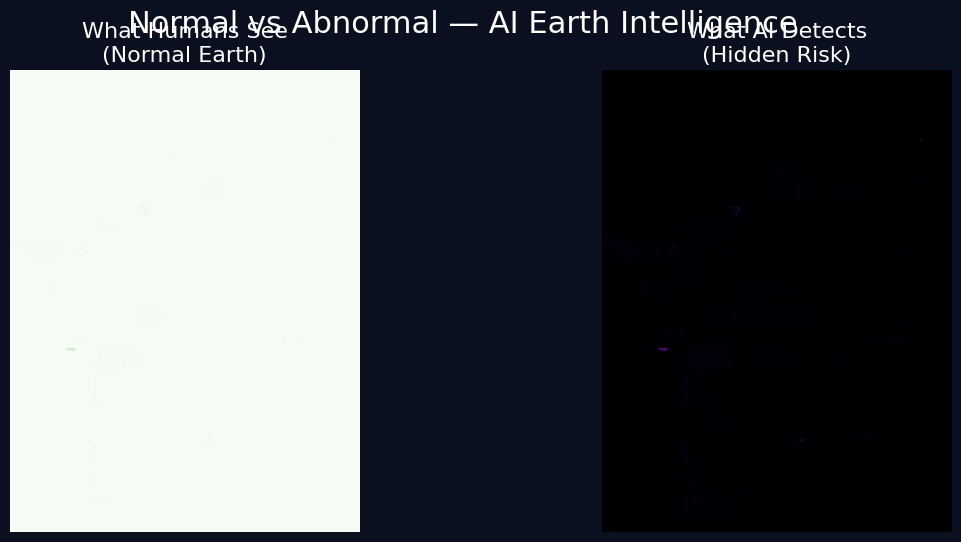

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6), facecolor='#0B1020')

# Normal (smoothed)
plt.subplot(1, 2, 1)
plt.imshow(anomaly_norm, cmap='Greens')
plt.title("What Humans See\n(Normal Earth)", color='white', fontsize=16)
plt.axis('off')

# Abnormal (AI)
plt.subplot(1, 2, 2)
plt.imshow(anomaly_norm, cmap='inferno')
plt.title("What AI Detects\n(Hidden Risk)", color='white', fontsize=16)
plt.axis('off')

plt.suptitle(
    "Normal vs Abnormal — AI Earth Intelligence",
    fontsize=22,
    color='white'
)

plt.show()


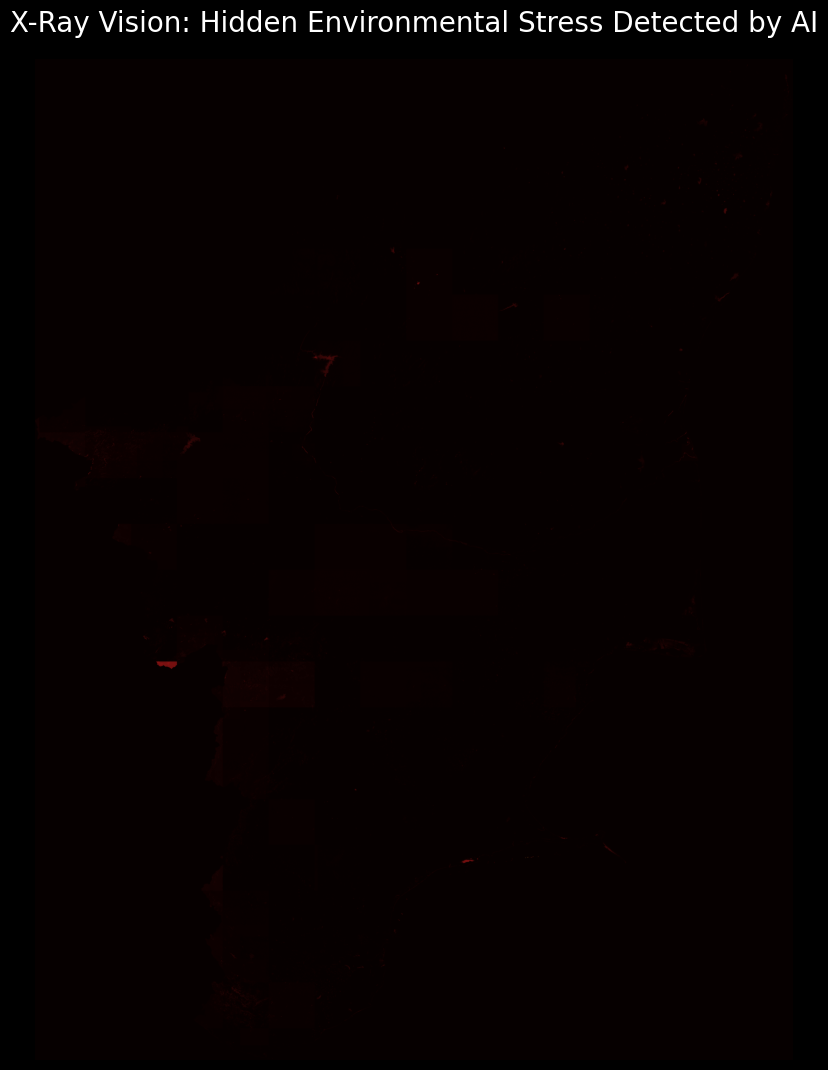

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 13), facecolor='black')

# Base grayscale
plt.imshow(anomaly_norm, cmap='gray')

# X-ray overlay
plt.imshow(anomaly_norm, cmap='hot', alpha=0.7)

plt.axis('off')

plt.title(
    "X-Ray Vision: Hidden Environmental Stress Detected by AI",
    fontsize=20,
    color='white',
    pad=20
)

plt.show()
